# Customer Churn Prediction (Batch Analytics)

## Business Context
Customer churn refers to customers discontinuing a company's service. 
High churn negatively impacts revenue and increases customer acquisition costs.

In highly competitive industries such as telecom, retaining existing customers
is significantly more cost-effective than acquiring new ones.

## Objective
The objective of this project is to:
- Predict customers who are likely to churn in the next period using historical data
- Identify key drivers of churn using explainable machine learning models
- Provide actionable business recommendations to reduce churn


In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

In [2]:
import os

# Get current notebook directory
notebook_dir = os.path.dirname(os.path.abspath('__file__'))

# Build data path
data_path = os.path.join(notebook_dir, '..', 'data', 'telco_customer_churn.csv')

# Load
df = pd.read_csv(data_path)

In [3]:
df.shape

(7043, 21)

In [4]:
df.head()

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,...,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,...,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   gender            7043 non-null   object 
 2   SeniorCitizen     7043 non-null   int64  
 3   Partner           7043 non-null   object 
 4   Dependents        7043 non-null   object 
 5   tenure            7043 non-null   int64  
 6   PhoneService      7043 non-null   object 
 7   MultipleLines     7043 non-null   object 
 8   InternetService   7043 non-null   object 
 9   OnlineSecurity    7043 non-null   object 
 10  OnlineBackup      7043 non-null   object 
 11  DeviceProtection  7043 non-null   object 
 12  TechSupport       7043 non-null   object 
 13  StreamingTV       7043 non-null   object 
 14  StreamingMovies   7043 non-null   object 
 15  Contract          7043 non-null   object 
 16  PaperlessBilling  7043 non-null   object 


In [6]:
df['Churn'].value_counts()

Churn
No     5174
Yes    1869
Name: count, dtype: int64

In [7]:
df['Churn'].value_counts(normalize=True)

Churn
No     0.73463
Yes    0.26537
Name: proportion, dtype: float64

## Data Overview

- The dataset contains customer-level demographic, service usage, and billing information.
- The target variable `Churn` indicates whether a customer has discontinued the service.
- Initial analysis shows the proportion of churned vs retained customers, indicating
  a moderate class imbalance that should be considered during model evaluation.

In [8]:
df.isnull().sum()

customerID          0
gender              0
SeniorCitizen       0
Partner             0
Dependents          0
tenure              0
PhoneService        0
MultipleLines       0
InternetService     0
OnlineSecurity      0
OnlineBackup        0
DeviceProtection    0
TechSupport         0
StreamingTV         0
StreamingMovies     0
Contract            0
PaperlessBilling    0
PaymentMethod       0
MonthlyCharges      0
TotalCharges        0
Churn               0
dtype: int64

In [9]:
# TotalCharges is a float quantity when we see in table but when we check data type it is stored as object
df['TotalCharges'] = pd.to_numeric(df['TotalCharges'], errors='coerce')

In [10]:
df.isnull().sum()

customerID           0
gender               0
SeniorCitizen        0
Partner              0
Dependents           0
tenure               0
PhoneService         0
MultipleLines        0
InternetService      0
OnlineSecurity       0
OnlineBackup         0
DeviceProtection     0
TechSupport          0
StreamingTV          0
StreamingMovies      0
Contract             0
PaperlessBilling     0
PaymentMethod        0
MonthlyCharges       0
TotalCharges        11
Churn                0
dtype: int64

In [11]:
df['TotalCharges'] = df['TotalCharges'].fillna(df['TotalCharges'].median())

In [12]:
df.drop(columns=['customerID'], inplace=True)

In [13]:
df['Churn'] = df['Churn'].map({'Yes': 1, 'No': 0})

In [14]:
cat_cols = df.select_dtypes(include='object').columns
num_cols = df.select_dtypes(exclude='object').columns

In [15]:
cat_cols, num_cols

(Index(['gender', 'Partner', 'Dependents', 'PhoneService', 'MultipleLines',
        'InternetService', 'OnlineSecurity', 'OnlineBackup', 'DeviceProtection',
        'TechSupport', 'StreamingTV', 'StreamingMovies', 'Contract',
        'PaperlessBilling', 'PaymentMethod'],
       dtype='object'),
 Index(['SeniorCitizen', 'tenure', 'MonthlyCharges', 'TotalCharges', 'Churn'], dtype='object'))

In [16]:
df_encoded = pd.get_dummies(df, columns=cat_cols, drop_first=True)

## Data Cleaning & Preprocessing

- Converted `TotalCharges` to numeric and handled missing values using median imputation.
- Dropped customer identifier as it does not contribute to churn prediction.
- Encoded the target variable into binary format.
- Applied one-hot encoding to categorical variables to make them suitable for machine learning models.


In [17]:
churn_rate = df_encoded['Churn'].mean()
print(f"Churn rate: {churn_rate:.2%}")

Churn rate: 26.54%


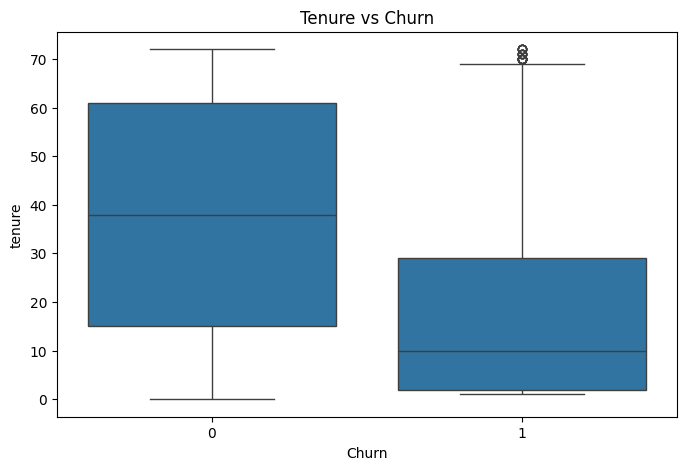

In [18]:
plt.figure(figsize=(8,5))
sns.boxplot(x='Churn', y='tenure', data=df_encoded)
plt.title('Tenure vs Churn')
plt.show()

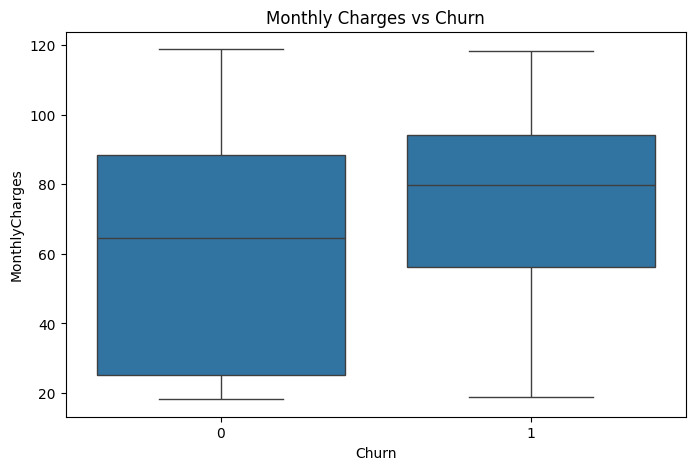

In [19]:
plt.figure(figsize=(8,5))
sns.boxplot(x='Churn', y='MonthlyCharges', data=df_encoded)
plt.title('Monthly Charges vs Churn')
plt.show()

In [20]:
contract_cols = [col for col in df_encoded.columns if 'Contract_' in col]

for col in contract_cols:
    churn_percent = df_encoded.groupby(col)['Churn'].mean()
    print(f"\n{col} churn rate:\n{churn_percent}")


Contract_One year churn rate:
Contract_One year
False    0.305745
True     0.112695
Name: Churn, dtype: float64

Contract_Two year churn rate:
Contract_Two year
False    0.340501
True     0.028319
Name: Churn, dtype: float64


## Exploratory Data Analysis (EDA) Summary

- Overall churn rate: ~26% (example)
- Customers with short tenure have higher churn rates.
- High monthly charges seem associated with increased churn.
- Month-to-month contract customers churn significantly more than long-term contracts.
- These insights will guide feature importance interpretation later.

In [21]:
df_encoded['tenure_bucket'] = pd.cut(
    df_encoded['tenure'], 
    bins=[0, 12, 24, 48, 60, 72], 
    labels=['0-12','13-24','25-48','49-60','61-72']
)

In [22]:
df_encoded = pd.get_dummies(df_encoded, columns=['tenure_bucket'], drop_first=True)

In [23]:
X = df_encoded.drop('Churn', axis=1)
y = df_encoded['Churn']

## Feature Engineering Summary

- Created tenure buckets to capture customer lifecycle stage.
- Created a total services feature to summarize customer engagement.
- Final feature set `X` contains numeric and encoded variables suitable for machine learning.

In [24]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

In [25]:
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

# Logistic Regression pipeline with scaling
logreg_pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('model', LogisticRegression(max_iter=1000, random_state=42))
])

logreg_pipeline.fit(X_train, y_train)

,steps,"[('scaler', ...), ('model', ...)]"
,transform_input,None
,memory,None
,verbose,False
,copy,True
,with_mean,True
,with_std,True
,penalty,'l2'
,dual,False
,tol,0.0001
,C,1.0


In [26]:
from sklearn.ensemble import RandomForestClassifier

rf_model = RandomForestClassifier(
    n_estimators=100,
    max_depth=5,
    random_state=42
)

rf_model.fit(X_train, y_train)

,n_estimators,100
,criterion,'gini'
,max_depth,5
,min_samples_split,2
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_features,'sqrt'
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,bootstrap,True
,oob_score,False


Logistic Regression Performance
Accuracy: 0.7984386089425124
Precision: 0.65
Recall: 0.5213903743315508
ROC-AUC: 0.8422666563331525


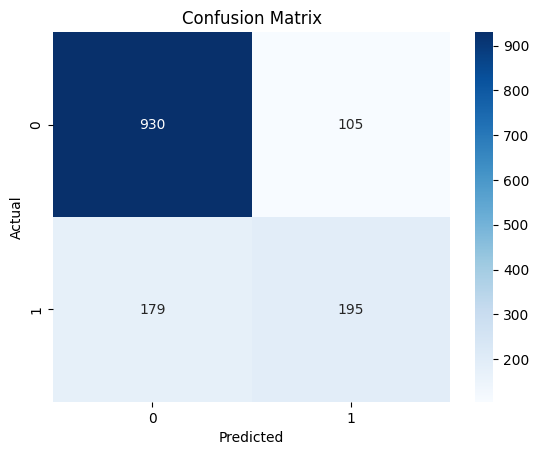

Random Forest Performance
Accuracy: 0.7906316536550745
Precision: 0.680365296803653
Recall: 0.3983957219251337
ROC-AUC: 0.8392725206024438


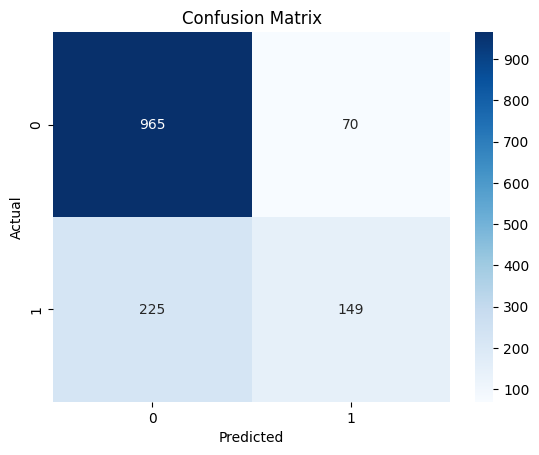

In [27]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, roc_auc_score, confusion_matrix

def evaluate_model(model, X_test, y_test):
    y_pred = model.predict(X_test)
    y_prob = model.predict_proba(X_test)[:,1]
    
    print("Accuracy:", accuracy_score(y_test, y_pred))
    print("Precision:", precision_score(y_test, y_pred))
    print("Recall:", recall_score(y_test, y_pred))
    print("ROC-AUC:", roc_auc_score(y_test, y_prob))
    
    cm = confusion_matrix(y_test, y_pred)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title('Confusion Matrix')
    plt.ylabel('Actual')
    plt.xlabel('Predicted')
    plt.show()

print("Logistic Regression Performance")
evaluate_model(logreg_pipeline, X_test, y_test)

print("Random Forest Performance")
evaluate_model(rf_model, X_test, y_test)

## Model Building Summary

- Logistic Regression used as a baseline model due to its interpretability.
- Random Forest captures non-linear relationships and interactions between features.
- Models evaluated using accuracy, precision, recall, and ROC-AUC to account for class imbalance.
- Confusion matrices used to visualize performance.
- These models provide a foundation for predicting churn in a batch setting.

In [28]:
importances = rf_model.feature_importances_
feature_names = X.columns

rf_feat_imp = pd.Series(importances, index=feature_names).sort_values(ascending=False)
rf_feat_imp[:10]  # top 10 features

tenure                                  0.211078
TotalCharges                            0.107239
Contract_Two year                       0.096492
InternetService_Fiber optic             0.090904
PaymentMethod_Electronic check          0.077181
MonthlyCharges                          0.055973
OnlineSecurity_Yes                      0.048428
Contract_One year                       0.029799
TechSupport_Yes                         0.027305
DeviceProtection_No internet service    0.026125
dtype: float64

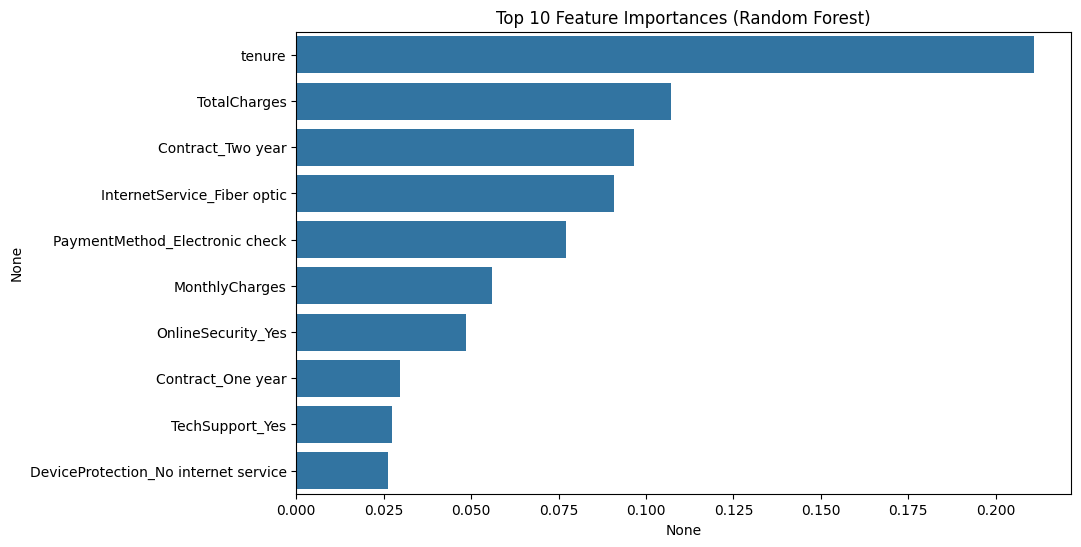

In [29]:
plt.figure(figsize=(10,6))
sns.barplot(x=rf_feat_imp[:10], y=rf_feat_imp[:10].index)
plt.title('Top 10 Feature Importances (Random Forest)')
plt.show()

In [30]:
coeffs = pd.Series(logreg_pipeline.named_steps['model'].coef_[0], index=X.columns).sort_values()
coeffs[:10]  # negative impact

tenure                                 -1.194435
MonthlyCharges                         -0.844897
Contract_Two year                      -0.647020
Contract_One year                      -0.294299
OnlineSecurity_Yes                     -0.113346
tenure_bucket_13-24                    -0.112655
Dependents_Yes                         -0.097958
OnlineBackup_No internet service       -0.089484
DeviceProtection_No internet service   -0.089484
StreamingTV_No internet service        -0.089484
dtype: float64

In [31]:
coeffs[-10:] # positive impact

DeviceProtection_Yes              0.069723
TotalCharges                      0.162418
PaymentMethod_Electronic check    0.177634
PaperlessBilling_Yes              0.187077
tenure_bucket_49-60               0.191292
MultipleLines_Yes                 0.239248
StreamingMovies_Yes               0.268903
StreamingTV_Yes                   0.269836
tenure_bucket_61-72               0.300799
InternetService_Fiber optic       0.788014
dtype: float64

## Feature Importance & Insights

- Random Forest shows that the most important features driving churn are:
    - Short tenure
    - High monthly charges
    - Month-to-month contracts
- Logistic Regression confirms similar trends:
    - Positive coefficients (increase churn): short tenure, multiple high-cost services
    - Negative coefficients (reduce churn): long-term contracts, higher engagement
- These insights help the business target high-risk customers with retention strategies.

In [32]:
# Using Random Forest as example
y_prob = rf_model.predict_proba(X_test)[:,1]

# Add probabilities to a DataFrame
pred_df = X_test.copy()
pred_df['Churn_Prob'] = y_prob
pred_df['Actual_Churn'] = y_test.values

In [33]:
def churn_risk_bucket(prob):
    if prob >= 0.6:
        return 'High'
    elif prob >= 0.4:
        return 'Medium'
    else:
        return 'Low'

pred_df['Risk_Bucket'] = pred_df['Churn_Prob'].apply(churn_risk_bucket)

In [34]:
pred_df['Risk_Bucket'].value_counts(normalize=True)

Risk_Bucket
Low       0.741661
Medium    0.175302
High      0.083038
Name: proportion, dtype: float64

## Batch Prediction Output & Risk Buckets

- Predicted churn probabilities for all customers in the test set.
- Categorized customers into High, Medium, and Low risk for retention targeting.
- Example insight: ~X% of customers fall into the high-risk category and should be prioritized for retention campaigns.
- This simulates a real-world batch scoring process, ready for business action.

## Business Recommendations

1. **High-Risk Customers (Churn Probability ≥ 0.6)**  
   - Offer personalized retention campaigns (discounts, loyalty programs).  
   - Focus on short-tenure and month-to-month customers.

2. **Medium-Risk Customers (0.4 ≤ Churn Probability < 0.6)**  
   - Provide targeted engagement (product bundles, usage tips).  
   - Monitor monthly behavior for early churn signals.

3. **Low-Risk Customers (Churn Probability < 0.4)**  
   - Minimal intervention required.  
   - Maintain standard communications and loyalty programs.

4. **Feature-Based Insights for Strategy**  
   - Long-term contracts reduce churn — consider promoting 1–2 year plans.  
   - High monthly charges increase churn — review pricing or offer flexible plans.  
   - Customer engagement (multiple services) lowers churn — encourage bundling.

## Limitations

- Dataset may not capture all behavioral or external factors influencing churn.
- Some features are proxies (e.g., total services) and may not fully represent engagement.
- Batch prediction assumes data distribution stays similar — may need retraining over time.
- No temporal or sequential modeling — churn trends over time are not captured.
- Class imbalance could affect performance; threshold tuning may improve high-risk identification.

## Executive Summary

- Built a batch churn prediction model using Logistic Regression and Random Forest.
- Identified key churn drivers: short tenure, month-to-month contracts, high monthly charges.
- Created churn probabilities and categorized customers into High, Medium, and Low risk.
- Recommendations include targeted retention campaigns for high-risk customers and strategic offers to reduce churn.
- The workflow is ready for batch scoring and can be extended to a real-time pipeline in the future.